In [1]:
import scipy.stats as stats
from matplotlib import colors
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def calculate_error_bounds(ds):
    
    pem = ds.mean(dim = 'ensemble_member')
    psd = ds.std(dim = 'ensemble_member', ddof=1)
    
    upperbound = pem + psd
    upperbound['aice'] = upperbound.aice.where(upperbound.aice < 1, 1)
    lowerbound = pem - psd 
    
    return upperbound, lowerbound, pem

In [3]:
free_ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE/free_ens.nc')
free = free_ds[['aice','vice','hi','aicen','vicen','vsnon','vsno']].mean(dim='ensemble_member')
truth = free_ds[['aice','vice','hi','aicen','vicen','vsnon','vsno']].isel({'ensemble_member':13})

In [34]:
case_list = ['SIT_f1_NORM_test', 'SIT_f1_BNRH_test', 'SIT_f101_NORM_test', 'SIT_f101_BNRH_test',
             'SIC_f1_NORM_test', 'SIC_f1_BNRH_test', 'SIC_f101_NORM_test', 'SIC_f101_BNRH_test',
             'AGR_f1_NORM_opt1', 'AGR_f1_BNRH_opt1', 'AGR_f101_NORM_opt1', 'AGR_f101_BNRH_opt1',
             'VIC_f1_NORM_test', 'VIC_f1_BNRH_test', 'VIC_f101_NORM_test', 'VIC_f101_BNRH_test',
             'AIC_f1_NORM_test', 'AIC_f1_BNRH_test', 'AIC_f101_NORM_test', 'AIC_f101_BNRH_test',
             'CAT_f1_NORM_opt1', 'CAT_f1_BNRH_opt1', 'CAT_f101_NORM_opt1', 'CAT_f101_BNRH_opt1',
            ]
CASES = []
for case in case_list:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/postprocessed_ens.nc')
    ds = ds.isel({'ni':2})
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    ds['time'] = pd.date_range('2011-01-02', '2011-12-31')
    
    CASES.append(ds[['aice','vice','hi','aicen','vicen','vsnon']])

In [39]:
variable = 'hi'
FREE = []
TRUE = []
EXPS = []

CASE_COPY = CASES.copy()
for case in CASES:
    up,down,em1 = calculate_error_bounds(case)
    
    # significance from free mean
    if variable == 'aice':
        FREE.append(stats.ttest_ind(em1.aice.sel(time=slice('2011-07-15','2011-10-01')), free.aice.sel(time=slice('2011-07-15','2011-10-01')), equal_var = False)[1])
    elif variable == 'vsno':
        FREE.append(stats.ttest_ind(em1.vsnon.sel(time=slice('2011-07-15','2011-10-01')).sum(dim='ncat'), free.vsno.sel(time=slice('2011-07-15','2011-10-01')), equal_var = False)[1])
    else:
        FREE.append(stats.ttest_ind(em1[variable], free[variable], equal_var = False)[1])  
    
    # significance from truth
    if variable == 'aice':
        TRUE.append(stats.ttest_ind(em1.aice.sel(time=slice('2011-07-15','2011-10-01')), truth.aice.sel(time=slice('2011-07-15','2011-10-01')), equal_var = False)[1])
    elif variable == 'vsno':
        TRUE.append(stats.ttest_ind(em1.vsnon.sel(time=slice('2011-07-15','2011-10-01')).sum(dim='ncat'), truth.vsno.sel(time=slice('2011-07-15','2011-10-01')), equal_var = False)[1])
    else:
        TRUE.append(stats.ttest_ind(em1[variable], truth[variable], equal_var = False)[1])  
    
    # significance from everything else
    CASE = []
    CASE_COPY.remove(case)
    for case2 in CASE_COPY: 
        up,down,em2 = calculate_error_bounds(case2)
        if variable == 'aice':
            CASE.append(stats.ttest_ind(em2.aice.sel(time=slice('2011-07-15','2011-10-01')), em1.aice.sel(time=slice('2011-07-15','2011-10-01')), equal_var = False)[1])
        elif variable == 'snow':
            CASE.append(stats.ttest_ind(em2.vsnon.sel(time=slice('2011-07-15','2011-10-01')).sum(dim='ncat'), em1.vsnon.sel(time=slice('2011-07-15','2011-10-01')).sum(dim='ncat'), equal_var = False)[1])
        else:
            CASE.append(stats.ttest_ind(em2[variable], em1[variable], equal_var = False)[1])
            
    EXPS.append(CASE)

In [40]:
empty = np.zeros((len(case_list), len(case_list)+2))
empty[:,-1] = FREE
empty[:,-2] = TRUE
for i in range(0, len(EXPS)):
    empty[i,i+1:-2] = EXPS[i]
    
case_list2 = [case_list[i][:-5] for i in range(0, len(case_list))]
case_list2.append('TRUTH')
case_list2.append('FREE')
thing = np.where(empty==0, np.nan, empty)

In [41]:
thing

array([[           nan, 6.95040128e-01, 9.83170905e-01, 6.73405365e-01,
        1.00376168e-14, 5.80037457e-15, 2.64819699e-11, 5.53362907e-12,
        7.34391539e-01, 9.92088039e-01, 9.70445682e-01, 9.02063490e-01,
        3.69712135e-01, 3.35939643e-01, 2.69451707e-01, 3.33462876e-01,
        8.21180013e-01, 3.89672677e-01, 8.68493104e-01, 2.21392744e-01,
        5.85983059e-01, 3.57082092e-01, 4.32276041e-01, 2.63534882e-01,
        4.97991858e-01, 2.81409557e-10],
       [           nan,            nan, 7.11027127e-01, 9.78129842e-01,
        5.69469409e-16, 3.25726562e-16, 1.55246068e-12, 3.13234761e-13,
        4.68609857e-01, 6.98028208e-01, 6.68806979e-01, 6.09996942e-01,
        6.13299811e-01, 5.69175696e-01, 4.74689719e-01, 5.64458129e-01,
        8.63101395e-01, 6.44636687e-01, 8.15454379e-01, 4.07582546e-01,
        8.80091405e-01, 5.98233133e-01, 6.94656638e-01, 4.66529742e-01,
        7.77411564e-01, 1.79726864e-11],
       [           nan,            nan,            nan

/glade/scratch/mollyw/ipykernel_60053/840242065.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = case_list2, fontsize=11, rotation = 90)
/glade/scratch/mollyw/ipykernel_60053/840242065.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = case_list2, fontsize=11, va="center", rotation_mode="anchor")


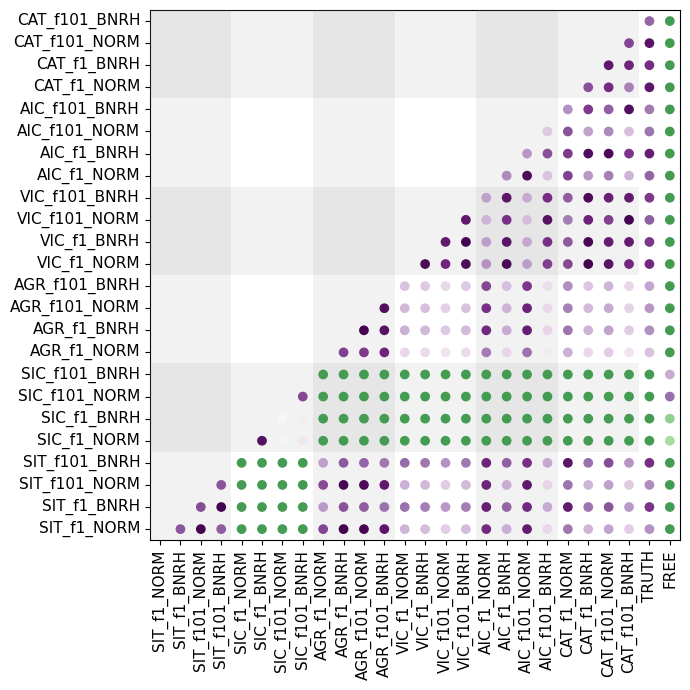

In [84]:
divnorm=colors.TwoSlopeNorm(vmin=-0.025, vcenter=0.05, vmax=1)

fig, ax = plt.subplots(figsize=(7,7))
for i in range(0,len(thing)):
    ys = np.tile(case_list[i][:-5],np.shape(thing)[1])
    plt.scatter(x = case_list2, y = ys, c = thing[i,:], cmap = plt.cm.PRGn_r, norm=divnorm, zorder = 6)
# axes[2].fill_between(x, lowerbound.vsnon.sum(dim='ncat')*100, upperbound.vsnon.sum(dim='ncat')*100, alpha=0.2, color = colors[count], zorder = 3)
   
ax.fill_between(np.arange(0,len(thing)+1)-0.5, np.tile(3.5,len(thing)+1), np.tile(7.5,len(thing)+1), color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)
ax.fill_between(np.arange(0,len(thing)+1)-0.5, np.tile(11.5,len(thing)+1), np.tile(15.5,len(thing)+1), color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)
ax.fill_between(np.arange(0,len(thing)+1)-0.5, np.tile(19.5,len(thing)+1), np.tile(23.5,len(thing)+1), color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)

ax.fill_betweenx(np.arange(0,len(thing)+1)-0.5, -0.5, 3.5, color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)
ax.fill_betweenx(np.arange(0,len(thing)+1)-0.5, 7.5, 11.5, color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)
ax.fill_betweenx(np.arange(0,len(thing)+1)-0.5, 15.5, 19.5, color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)

ax.set_xticklabels(labels = case_list2, fontsize=11, rotation = 90)
ax.set_yticklabels(labels = case_list2, fontsize=11, va="center", rotation_mode="anchor")
plt.ylim([-0.5,23.5])
plt.xlim([-0.5,25.5])
# plt.colorbar()
plt.tight_layout()
plt.savefig('figures/significance.png', dpi=300, bbox_inches='tight')